# Training with Sklearn


**In this notebook:**
* load training and test data
* oversample training data with ADASYN
* define grisearch for logistic regression and svc model
* test best models on test data set
* evaluate predictions 

**Key insights:**
* Without oversampling, all test data is assigned to the most representative classes (1,2,4 and 7).
* learning does not converge
* minimum logloss 2.02
* maximum accuracy 32%


## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyternotify
%autonotify -a 30

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time

import sys

sys.path.append("../utils/")
from evaluation import Evaluation

<IPython.core.display.Javascript object>

Using TensorFlow backend.


## Prepare Data

In [2]:
# Load Data
data_path = "../../data/msk-redefining-cancer-treatment"
x_train = np.load(os.path.join(data_path, "processed/x_train"), allow_pickle=True)
y_train = np.load(os.path.join(data_path, "processed/y_train"), allow_pickle=True)
x_test = np.load(os.path.join(data_path, "processed/x_test"), allow_pickle=True)
y_test = np.load(os.path.join(data_path, "processed/y_test"), allow_pickle=True)
print("Training Data Shape:".ljust(20), x_train.shape)
print("Test Data Shape:".ljust(20), x_test.shape)

Training Data Shape: (3683, 110)
Test Data Shape:     (986, 110)


In [3]:
# Data needed for weighting
all_1_over_9 = pd.read_csv(os.path.join(data_path, "external/submission_1_over_9.csv"))
all_1_over_9 = all_1_over_9.drop("ID", axis=1)

In [4]:
# Not all test samples have a solution -> ids - with solution
ids = pd.read_csv(os.path.join(data_path, "raw/stage_2_private_solution.csv")).ID.values

In [5]:
# Oversample Training Data
x_train, y_train = ADASYN(sampling_strategy="auto").fit_sample(x_train, y_train)
print("Training Data Shape after Oversampling:", x_train.shape)

Training Data Shape after Oversampling: (9493, 110)


<BarContainer object of 9 artists>

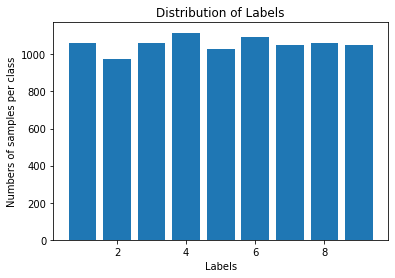

In [6]:
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Numbers of samples per class")
plt.bar(
    np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1]
)

In [7]:
# Normalize (if not already during preprocessing)
normalizer = MinMaxScaler()
x_train = normalizer.fit_transform(x_train)
x_test = normalizer.transform(x_test)

## Gridsearch Function

In [8]:
def get_best_estimator(clf, parameters, scoring, n_jobs=12):
    grid_search = GridSearchCV(
        clf, param_grid=parameters, scoring="neg_log_loss", verbose=1
    )

    print("Performing grid search...")
    print("parameters:")
    pprint(parameters)
    t0 = time()

    grid_search.fit(x_train, y_train.astype(str))

    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    print("Done!")
    return grid_search.best_estimator_

## Logistic Regression Classifier

### Grid-Search

In [27]:
# define model
clf = LogisticRegression()

In [28]:
# define parameters
parameters = {
    'tol':(1e-5,1e-4,1e-3),
    "class_weight": (None, "balanced"),
    'solver': ('newton-cg', 'saga'), 
    'max_iter': (5000, 10000),
}
scoring = "neg_log_loss"
n_jobs = 12

In [29]:
best_clf = get_best_estimator(clf=clf, parameters=parameters, scoring=scoring, n_jobs=n_jobs)

Performing grid search...
parameters:
{'class_weight': (None, 'balanced'),
 'max_iter': (5000, 10000),
 'solver': ('newton-cg', 'saga'),
 'tol': (1e-05, 0.0001, 0.001)}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 19.8min finished


done in 1191.971s

Best score: -1.194
Best parameters set:
	class_weight: None
	max_iter: 5000
	solver: 'newton-cg'
	tol: 0.001
Done!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Predict Test Labels

In [ ]:
pred = best_clf.predict_proba(x_test) 
print('Sample of Prediction: ', pred[0])

### Weighting of Predictions

In [ ]:
# weighted average
weighting = (6, 4)
submission_weighted = (pred * weighting[0] + all_1_over_9 * weighting[1]) / 10
submission_weighted.shape

### Evaluate Classifier

In [32]:
# Filter ids with given label 
pred_weighted = np.take(submission_weighted, (list(ids - 1)), axis=0)

Accuracy: 0.32 Log loss: 2.0205699501486203 F1 micro: 0.32 F1 macro: 0.1325481006625616


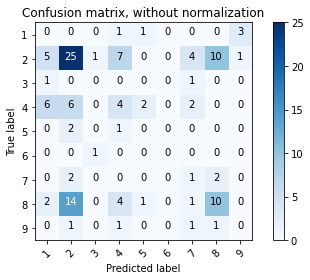

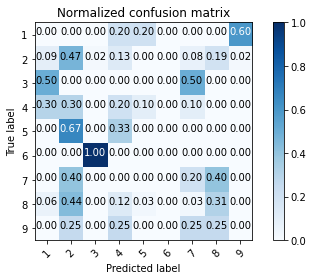

In [33]:
ev = Evaluation(y_pred = pred_weighted.to_numpy(), y_test=y_test)
ev.entire_evaluation()

## Linear SVC Classifier

### Grid-Search

In [9]:
# define model
svc_clf = svm.SVC(kernel='linear',probability=True)

In [14]:
# define parameters
svc_parameters = {
    'tol':(1e-5,1e-4,1e-3),
    'C':(0.5, 1),
    'class_weight':(None, 'balanced'), 
    'max_iter': (5000, 10000),
}
svc_scoring = 'accuracy'
svc_n_jobs = 8

In [ ]:
best_svc_clf = get_best_estimator(clf=svc_clf, parameters=svc_parameters, scoring=svc_scoring, n_jobs=svc_n_jobs )

Performing grid search...
parameters:
{'C': (0.5, 1),
 'class_weight': (None, 'balanced'),
 'max_iter': (5000, 10000),
 'tol': (1e-05, 0.0001, 0.001)}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### Predict Test Labels

In [ ]:
pred = best_svc_clf.predict_proba(x_test) 
print('Sample of Prediction: ', pred[0])

### Weighting of Predictions

In [ ]:
# weighted average
weighting = (6, 4)
submission_weighted = (pred * weighting[0] + all_1_over_9 * weighting[1]) / 10
submission_weighted.shape

### Evaluate Classifier

In [ ]:
# Filter ids with given label 
pred_weighted = np.take(submission_weighted, (list(ids - 1)), axis=0)

In [ ]:
ev = Evaluation(y_pred = pred_weighted.to_numpy(), y_test=y_test)
ev.entire_evaluation()